In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
from natsort import natsorted

## !!NEEDs refactoring - pipe with integrate over time from paraview

In [2]:
RASFile = r"IntegrationOverTime/deploy9_RANS.csv"
LESFile = r"IntegrationOverTime/deploy9_LES.csv"

In [3]:
RASv = pd.read_csv(RASFile)
LESv = pd.read_csv(LESFile)

In [4]:
ofTimeStep = 3600. / 86400 
RASv['RealTime (d)'] = RASv['Time'] * ofTimeStep
LESv['RealTime (d)'] = LESv['Time'] * ofTimeStep

In [5]:
## Matplotlib global settings
#plt.rcParams["font.family"] = "lato"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 10
plt.rcParams["axes.labelcolor"] = 'k'
plt.rcParams["axes.labelpad"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['xtick.color'] = 'dimgray'
plt.rcParams['ytick.color'] = 'dimgray'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

Axy = 0.29*0.15
RASReg = linregress(RASv['RealTime (d)'],RASv["avg(CsPos)"]/Axy)
LESReg = linregress(LESv['RealTime (d)'],LESv["avg(CsPos)"]/Axy)

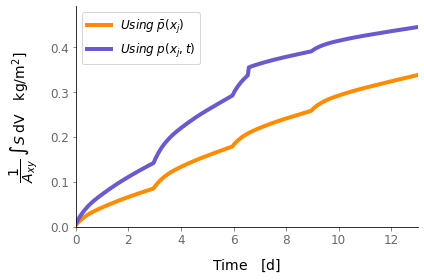

In [6]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(RASv['RealTime (d)'],RASv["avg(CsPos)"]/Axy,
        lw=4,label=r'${Using \; \bar{p}(x_j)}$',c='darkorange')
#ax.axline((0,RASReg.intercept),slope=RASReg.slope,c='darkorange',ls='dotted')

ax.plot(LESv['RealTime (d)'],LESv["avg(CsPos)"]/Axy,
        lw=4,label=r'${Using \; p(x_j,t)}$',c='slateblue')
#ax.axline((0,LESReg.intercept),slope=LESReg.slope,c='slateblue',ls='dotted')

ax.set_xlabel(r"$\mathsf{Time} \quad  \mathsf{[d]}$")
ax.set_ylabel(r"$\dfrac{1}{A_{xy}} \; \int S \; \mathsf{dV} \quad \mathsf{kg/m^2]}$")
ax.set(xlim=[0,13],ylim=[0,0.49])
ax.legend(fontsize=12)

#ax.text(11,0.45,"{:.2E}".format(LESReg.slope) + r" $\mathsf{kg/d/m^2} \; \measuredangle$",ha='right',c='slateblue')
#ax.text(12.4,0.22,"$\measuredangle \;$" + "{:.2E}".format(RASReg.slope) + r" $\mathsf{kg/d/m^2}$",ha='right',c='darkorange')

#plt.savefig("IntegrationOverTime/Integral.svg")
plt.show()

In [7]:
def retrieveVariables(path,variables,parseKeyword = "top"):
    listOfFilesInPath = natsorted(os.listdir(path))
    justTimeSteps = [f for f in listOfFilesInPath if f.replace('.','',1).isdigit()][1:]  #Ignore zero time
    
    time_float = [float(t) for t in justTimeSteps]
    results = pd.DataFrame({'Time (s)':np.array(time_float)})
    
    for variable in variables:
        ## Create a folder for the extracted variable
        folderForParsedTimesteps =  f"{path}/{variable}All"
        os.system(f"rm -rf {folderForParsedTimesteps}; mkdir {folderForParsedTimesteps}")
        
        varList = list()
        
        for time in justTimeSteps:
            fileToDump = f"{folderForParsedTimesteps}/{time}"
            sedParser = f"sed -n '/{parseKeyword}/,/)$/p' {path}/{time}/{variable} | sed -n '/^(/,/)/p' | sed '1d; $d' > {fileToDump}"
            os.system(sedParser)
            this = np.loadtxt(fileToDump)
            varList.append(this)
        
        results[f"{variable}"] = varList

    return results

## Elliot-Brooks phi
hydCond = 1.0E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
settling_vel = 6.13E-6 ##From Jin2018
Axy = bed_wavelenght*channel_width

qBar = (2*hydCond * head_m / bed_wavelenght) * np.tanh(2*np.pi*depth_bed/bed_wavelenght)
print("qBar = {:.2E} m/s".format(qBar))

#qBar += 0.5 * porosity * settling_vel
print("qBar = {:.2E} m/s".format(qBar))

qBar *= Axy
print("qBar = {:.2E} m3/s".format(qBar))

qBar = 3.19E-06 m/s
qBar = 3.19E-06 m/s
qBar = 1.39E-07 m3/s


In [9]:
fields = ["Cw","phi"]
RANS = retrieveVariables("./deployFull9_RANS_OFOut/",fields)
LES  = retrieveVariables("./deployFull9_LES_OFOut/deployFull9/",fields)

In [10]:
for df in [RANS,LES]:
    df['sumPhiIn (m3/s)'] = [ np.sum(np.maximum(-p,0)) for p in df['phi'] ]
    df['Time (d)'] = df['Time (s)']/86400
    df['massIn (kg/s/m2)'] = [ np.sum(np.multiply(-p,c))/Axy for p,c in zip(df['phi'],df['Cw']) ]
    
CwInSurfaceWater = pd.read_csv("Cw_dataTable.csv")
CwInSurfaceWater['Time(d)'] = CwInSurfaceWater['Time(s)'] / 86400
CwInSurfaceWater['massIn (kg/s/m2)'] = CwInSurfaceWater['Conc(kg/m3)'] * qBar / Axy

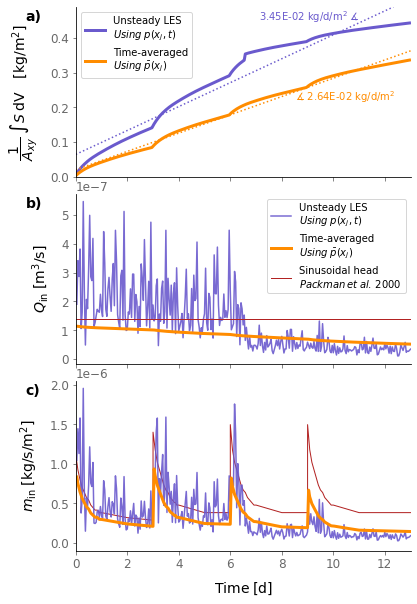

In [11]:
plt.rcParams["legend.fontsize"] = 10

legLab = {'LES':'Unsteady LES\n' + r"${Using \; p(x_j,t)}$",
          'RAS':'Time-averaged\n' + r"${Using \; \bar{p}(x_j)}$",
          'P20':'Sinusoidal head\n' + "$\mathit{Packman\,et\;al.\,2000}$"}

fig,axs = plt.subplots(3,1,figsize=[6,10],sharex=True,
                       gridspec_kw={"hspace":0.1},squeeze=True)
ax = axs[0]
ax.plot(LESv['RealTime (d)'],LESv["avg(CsPos)"]/Axy,
        lw=3,label=legLab['LES'],c='slateblue')
ax.axline((0,LESReg.intercept),slope=LESReg.slope,c='slateblue',ls='dotted')

ax.plot(RASv['RealTime (d)'],RASv["avg(CsPos)"]/Axy,
        lw=3,label=legLab['RAS'],c='darkorange')
ax.axline((0,RASReg.intercept),slope=RASReg.slope,c='darkorange',ls='dotted')

ax.set_ylabel(r"$\dfrac{1}{A_{xy}} \; \int S \; \mathsf{dV} \quad \mathsf{[kg/m^2]}$")
ax.set(xlim=[0,13],ylim=[0,0.49])
ax.legend(fontsize=10)

ax.text(11,0.45,"{:.2E}".format(LESReg.slope) + r" $\mathsf{kg/d/m^2} \; \measuredangle$",ha='right',c='slateblue')
ax.text(12.4,0.22,"$\measuredangle \;$" + "{:.2E}".format(RASReg.slope) + r" $\mathsf{kg/d/m^2}$",ha='right',c='darkorange')

#####################
ax = axs[1]
ax.plot(LES['Time (d)'],LES['sumPhiIn (m3/s)'],label=legLab['LES'],
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(RANS['Time (d)'],RANS['sumPhiIn (m3/s)'],label=legLab['RAS'],
        c='darkorange',lw=3)
ax.axhline(y=qBar,label=legLab['P20'],
           c='firebrick',lw=1)
ax.set(ylabel=r"$Q_\mathsf{in} \; \mathsf{[m^3/s]}$",xlim=(0,13))
ax.legend()

ax = axs[2]
ax.plot(CwInSurfaceWater['Time(d)'],CwInSurfaceWater['massIn (kg/s/m2)'],label='Steady-state \nPackman2000',
        c='firebrick',lw=1)
ax.plot(LES['Time (d)'],LES['massIn (kg/s/m2)'],label='Unsteady LES',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(RANS['Time (d)'],RANS['massIn (kg/s/m2)'],label='Time-averaged',
        c='darkorange',lw=3)
ax.set(ylabel=r"$m_\mathsf{in} \; \mathsf{[kg/s/m^2]}$",xlabel=r"$\mathsf{Time \; [d]}$",xlim=(0,13))

for ax,l in zip(axs,['a)','b)','c)']):
    ax.text(-0.15,0.92,l,transform=ax.transAxes,fontsize=14,fontweight='bold')
                
plt.savefig("InterfaceFluxes.svg")
plt.show()

In [12]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']

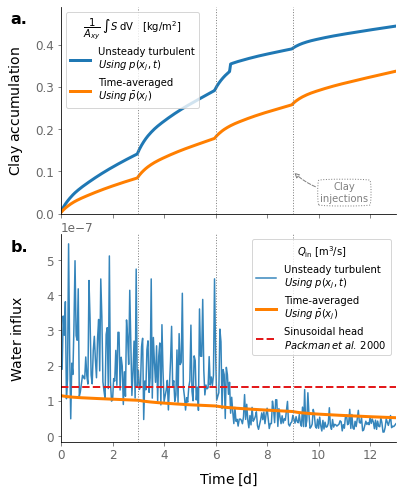

In [13]:
plt.rcParams["legend.fontsize"] = 10

legLab = {'LES':'Unsteady turbulent\n' + r"${Using \; p(x_j,t)}$",
          'RAS':'Time-averaged\n' + r"${Using \; \bar{p}(x_j)}$",
          'P20':'Sinusoidal head\n' + "$\mathit{Packman\,et\;al.\,2000}$"}

fig,axs = plt.subplots(2,1,figsize=[6,8],sharex=True,
                       gridspec_kw={"hspace":0.1},squeeze=True)

#####################
ax = axs[1]
ax.plot(LES['Time (d)'],LES['sumPhiIn (m3/s)'],label=legLab['LES'],
        c=colors[1],alpha=0.9,lw=1.5)
ax.plot(RANS['Time (d)'],RANS['sumPhiIn (m3/s)'],label=legLab['RAS'],
        c=colors[-1],lw=3)
ax.axhline(y=qBar,label=legLab['P20'],
           c=colors[5],lw=2,ls='dashed')
ax.set_ylabel(r"${\rm Water \; influx}$")
ax.legend(title=r"$Q_\mathsf{in} \; \mathsf{[m^3/s]}$")

######################
ax = axs[0]
ax.plot(LESv['RealTime (d)'],LESv["avg(CsPos)"]/Axy,
        lw=3,label=legLab['LES'],c=colors[1])
#ax.axline((0,LESReg.intercept),slope=LESReg.slope,c='slateblue',ls='dotted')

ax.plot(RASv['RealTime (d)'],RASv["avg(CsPos)"]/Axy,
        lw=3,label=legLab['RAS'],c=colors[-1])
#ax.axline((0,RASReg.intercept),slope=RASReg.slope,c='darkorange',ls='dotted')

ax.set_ylabel(r"${\rm Clay \; accumulation}$")
ax.set(xlim=[0,13],ylim=[0,0.49])
ax.legend(fontsize=10,title=r"$\dfrac{1}{A_{xy}} \; \int S \; \mathsf{dV} \quad \mathsf{[kg/m^2]}$",loc='upper left')

########################

kw_clayinjections = dict(lw=1,c='gray',ls='dotted')

for ax,l in zip(axs,['a.','b.']):
    ax.text(-0.15,0.92,l,transform=ax.transAxes,fontsize=16,fontweight='bold')
    ax.axvline(x=3,**kw_clayinjections)
    ax.axvline(x=6,**kw_clayinjections)
    ax.axvline(x=9,**kw_clayinjections)

ann = axs[0].annotate("Clay\ninjections",c='gray',
                  xy=(9,0.1), xycoords='data',
                  xytext=(11,0.05), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='gray',ls='dotted'),
                  arrowprops=dict(arrowstyle="-|>",ls='dashed',
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='gray'))

ax.set_xlabel(r"$\mathsf{Time \; [d]}$")
fig.align_ylabels(axs)
#plt.savefig("InterfaceFluxes.svg")
plt.show()